<a href="https://colab.research.google.com/github/atsss/Deep-Learning-for-Computer-Vision-with-Python-and-TensorFlow/blob/main/Human_Emotions_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Data download


> https://gemini.google.com/app/de3364032c27214c



In [5]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("muhammadhananasghar/human-emotions-datasethes")

print("Path to dataset files:", path)

100%|██████████| 309M/309M [00:01<00:00, 188MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4


In [6]:
!pwd

/content


In [7]:
!mv /root/.cache/kagglehub/datasets/muhammadhananasghar/human-emotions-datasethes/versions/4 /content/

In [8]:
!mv /content/4 /content/dataset

## Define variables

In [9]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plotting bar chart
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import pathlib
import io
import os
import time
import random
from google.colab import files
from PIL import Image

In [10]:
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
import matplotlib.cm as cm
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import (GlobalAveragePooling2D, Activation, MaxPooling2D, Add, Conv2D, MaxPool2D, Dense,
                                     Flatten, InputLayer, BatchNormalization, Input, Embedding, Permute,
                                     Dropout, RandomFlip, RandomRotation, LayerNormalization, MultiHeadAttention,
                                     RandomContrast, Rescaling, Resizing, Reshape)
from tensorflow.keras.losses import BinaryCrossentropy,CategoricalCrossentropy, SparseCategoricalCrossentropy
from tensorflow.keras.metrics import Accuracy,TopKCategoricalAccuracy, CategoricalAccuracy, SparseCategoricalAccuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import (Callback, CSVLogger, EarlyStopping, LearningRateScheduler,
                                        ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.regularizers  import L2, L1
from tensorflow.train import BytesList, FloatList, Int64List
from tensorflow.train import Example, Features, Feature
from google.colab import drive

In [11]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
val_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"

In [12]:
CONFIGURATION = {
    "BATCH_SIZE": 32,
    "IM_SIZE": 256,
    "LEARNING_RATE": 1e-3,
    "N_EPOCHS": 20,
    "DROPOUT_RATE": 0.0,
    "REGULARIZATION_RATE": 0.0,
    "N_FILTERS": 6,
    "KERNEL_SIZE": 3,
    "N_STRIDES": 1,
    "POOL_SIZE": 2,
    "N_DENSE_1": 1024,
    "N_DENSE_2": 128,
    "NUM_CLASSES": 3,
    "PATCH_SIZE": 16,
    "PROJ_DIM": 768,
    "CLASS_NAMES": ["angry", "happy", "sad"],
}

## Dataset Loading

In [13]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 6799 files belonging to 3 classes.


In [14]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_directory,
    labels='inferred',
    label_mode='categorical',
    class_names=CONFIGURATION["CLASS_NAMES"],
    color_mode='rgb',
    batch_size=CONFIGURATION["BATCH_SIZE"],
    image_size=(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
    shuffle=True,
    seed=99,
)

Found 2278 files belonging to 3 classes.


In [15]:
# for i in val_dataset.take(1):
#   print(i)

## Dataset Visualization

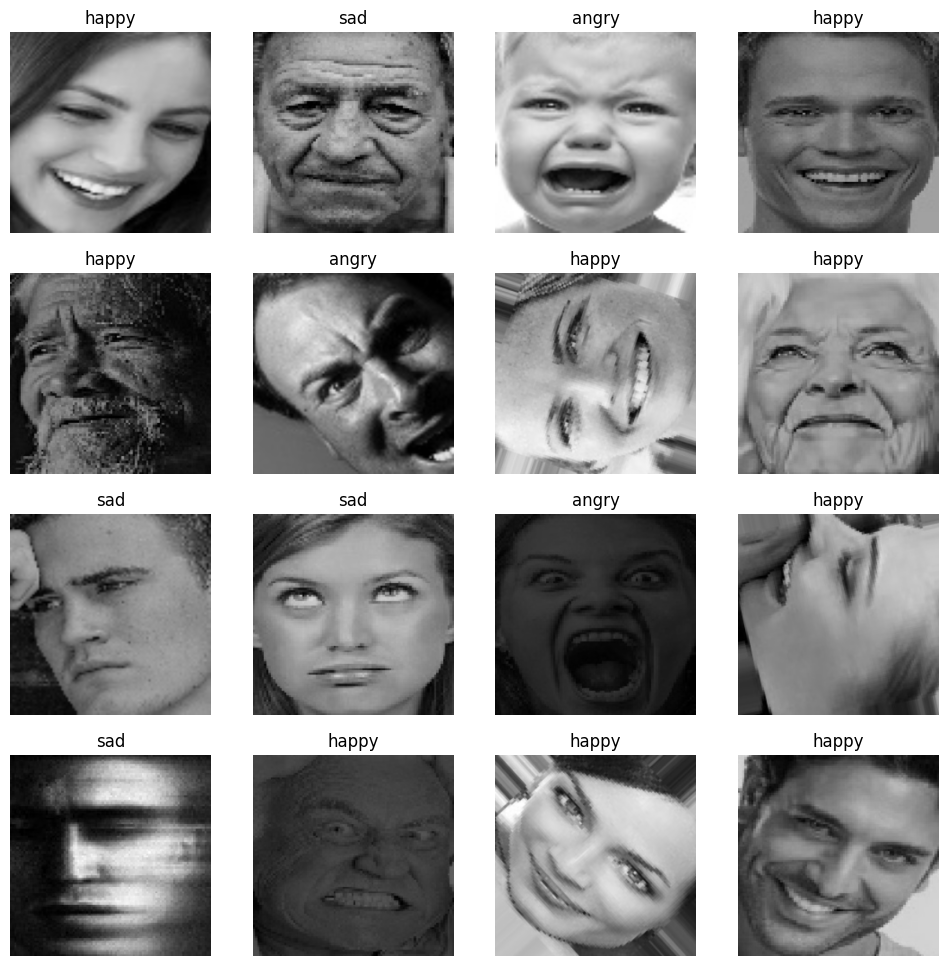

In [34]:
plt.figure(figsize = (12,12))

for images, labels in train_dataset.take(1):
  for i in range(16):
    # print(tf.argmax(labels[i], axis = 0).numpy())
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)
    plt.title(CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = 0).numpy()])
    plt.axis("off")

## Dataset Preparation
- prefetchとは？
  - 事前読み込み: TensorFlowのデータパイプラインにおいて、次のバッチのデータを事前に読み込んでおく処理です。
  - 並列処理: GPUやTPUなどのアクセラレータが次の計算の準備ができる間に、データの読み込みを行うことで、処理のオーバーヘッドを減らし、学習の効率を向上させることができます。
  - tf.data.AUTOTUNE: この引数は、TensorFlowに最適な並列化のレベルを自動的に選択させることを意味します。システムの資源やデータセットの特性に合わせて、最適なパフォーマンスが得られるように、TensorFlowが自動的にチューニングを行います。

In [22]:
training_dataset = (
    train_dataset
    .map(augment_layer, num_parallel_calls = tf.data.AUTOTUNE)
    .prefetch(tf.data.AUTOTUNE)
)

In [23]:
validation_dataset = (
    val_dataset
    .prefetch(tf.data.AUTOTUNE)
)

In [24]:
resize_rescale_layers = tf.keras.Sequential([
       Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]),
       Rescaling(1./255),
])

### コードの説明
このコードは、TensorFlowのKerasを用いて、画像の前処理を行うためのレイヤーを定義しています。具体的には、画像のサイズを変更し、ピクセル値を正規化する処理を行っています。

#### 各レイヤーの役割
- Resizing(CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"]):
  - 画像のサイズを、CONFIGURATION["IM_SIZE"] × CONFIGURATION["IM_SIZE"] に変更します。
  - 画像の縦横比が維持されない可能性があるため、アスペクト比を維持したい場合は、別のレイヤーを使用する必要があります。
- Rescaling(1./255):
  - 画像のピクセル値を0から255の範囲から、0から1の範囲に正規化します。
  - 多くのニューラルネットワークでは、入力データは0から1の範囲に正規化することが一般的です。

#### このレイヤー群の目的
- 画像の標準化:
  - 異なるサイズやピクセル値の範囲の画像を、統一的なサイズと範囲に揃えることで、ニューラルネットワークの学習を安定化させます。
- モデルへの入力準備:
  - ニューラルネットワークの多くは、0から1の範囲の入力データを期待するため、このレイヤーでデータを適切な形式に変換します。

#### 全体的な処理の流れ
1. 入力された画像が、Resizingレイヤーによって指定されたサイズにリサイズされます。
2. リサイズされた画像が、Rescalingレイヤーによって、ピクセル値が0から1の範囲に正規化されます。
3. 正規化された画像が、次のレイヤー（例えば、畳み込み層など）に渡されます。

## Modeling
### Lenet

In [16]:
# lenet_model = tf.keras.Sequential(
#     [
#     InputLayer(input_shape = (None, None, 3), ),

#     resize_rescale_layers,

#     Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
#           activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
#     BatchNormalization(),
#     MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
#     Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

#     Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
#           activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
#     BatchNormalization(),
#     MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

#     Flatten(),

#     Dense( CONFIGURATION["N_DENSE_1"], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
#     BatchNormalization(),
#     Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

#     Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
#     BatchNormalization(),

#     Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

# ])

# lenet_model.summary()

In [25]:
lenet_model = tf.keras.Sequential(
    [
    InputLayer(input_shape = (None, None, 3), ),

    resize_rescale_layers,

    Conv2D(filters = CONFIGURATION["N_FILTERS"] , kernel_size = CONFIGURATION["KERNEL_SIZE"], strides = CONFIGURATION["N_STRIDES"] , padding='valid',
          activation = 'relu',kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"] ),

    Conv2D(filters = CONFIGURATION["N_FILTERS"]*2 + 4, kernel_size = CONFIGURATION["KERNEL_SIZE"], strides=CONFIGURATION["N_STRIDES"], padding='valid',
          activation = 'relu', kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    MaxPool2D (pool_size = CONFIGURATION["POOL_SIZE"], strides= CONFIGURATION["N_STRIDES"]*2),

    Flatten(),

    Dense( 100, activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),
    Dropout(rate = CONFIGURATION["DROPOUT_RATE"]),

    Dense( 10, activation = "relu", kernel_regularizer = L2(CONFIGURATION["REGULARIZATION_RATE"])),
    BatchNormalization(),

    Dense(CONFIGURATION["NUM_CLASSES"], activation = "softmax"),

])

lenet_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_2 (Sequential)            │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 254, 254, 6)         │             168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 254, 254, 6)         │              24 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 127, 127, 6)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 125, 125, 16)        │             880 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 125, 125, 16)        │              64 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 62, 62, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 61504)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │       6,150,500 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 100)                 │             400 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 10)                  │              40 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 3)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 6,153,119 (23.47 MB)

 Trainable params: 6,152,855 (23.47 MB)

 Non-trainable params: 264 (1.03 KB)

## Training

In [26]:
loss_function = CategoricalCrossentropy()

from_logits=True または from_logits=False は、tf.keras.losses.CategoricalCrossentropy などのクロスエントロピー損失関数を用いる際に、モデルの出力値が何であるかを示すためのパラメータです。

from_logits=False: モデルの出力値が、すでにsoftmax関数を通した確率値であることを示します。
from_logits=True: モデルの出力値が、softmax関数を通す前のロジット値であることを示します。ロジットとは、softmax関数の入力値であり、実質的に負の無限大から正の無限大までの任意の値を取ることができます。

In [27]:
y_true = [[0, 1, 0], [0, 0, 1]]
y_pred = [[0.05, 0.95, 0], [0.1, 0.05, 0.85]]
# Using 'auto'/'sum_over_batch_size' reduction type.
cce = tf.keras.losses.CategoricalCrossentropy()
print(cce(y_true, y_pred).numpy())

0.1069061


In [28]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [29]:
lenet_model.compile(
    optimizer = Adam(learning_rate = CONFIGURATION["LEARNING_RATE"]),
    loss = loss_function,
    metrics = metrics,)

In [30]:
history = lenet_model.fit(
    training_dataset,
    validation_data = validation_dataset,
    epochs = CONFIGURATION["N_EPOCHS"],
    verbose = 1
    )

Epoch 1/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 75s 304ms/step - accuracy: 0.4598 - loss: 1.1002 - top_k_accuracy: 0.7669 - val_accuracy: 0.4987 - val_loss: 1.0056 - val_top_k_accuracy: 0.7853
Epoch 2/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 70s 274ms/step - accuracy: 0.6323 - loss: 0.8186 - top_k_accuracy: 0.8753 - val_accuracy: 0.5544 - val_loss: 0.9418 - val_top_k_accuracy: 0.8112
Epoch 3/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 57s 266ms/step - accuracy: 0.6678 - loss: 0.7494 - top_k_accuracy: 0.8860 - val_accuracy: 0.5558 - val_loss: 0.9278 - val_top_k_accuracy: 0.8297
Epoch 4/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 83s 269ms/step - accuracy: 0.7048 - loss: 0.6849 - top_k_accuracy: 0.9022 - val_accuracy: 0.4574 - val_loss: 1.0830 - val_top_k_accuracy: 0.7814
Epoch 5/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 58s 272ms/step - accuracy: 0.7342 - loss: 0.6277 - top_k_accuracy: 0.9199 - val_accuracy: 0.6853 - val_loss: 0.7831 - val_top_k_accuracy: 0.8806
Epoch 6/20
213/213 ━━━━━━━━━━━━━━━━━━━━ 58s 269ms/step - accuracy: 0.7583 -

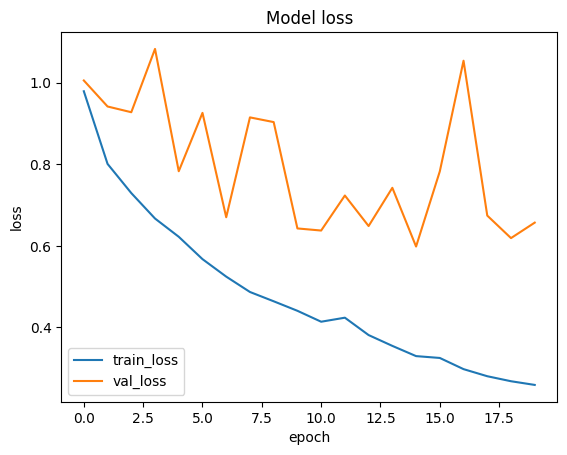

In [31]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

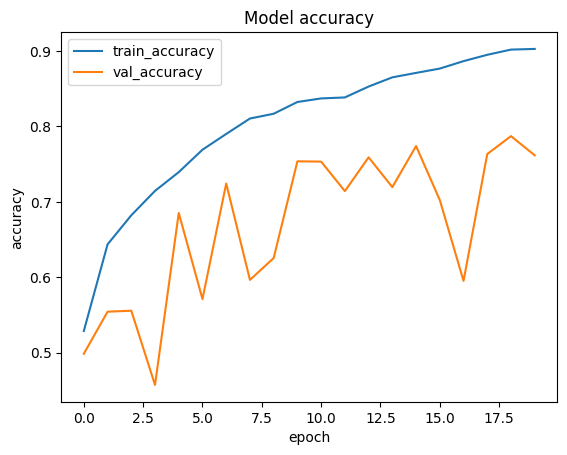

In [32]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

## Evaluation

In [33]:
lenet_model.evaluate(validation_dataset)

72/72 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.7674 - loss: 0.6656 - top_k_accuracy: 0.9105


[0.6571205258369446, 0.761633038520813, 0.9183494448661804]

## Testing

In [26]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/test/sad/123731.jpg")

im = tf.constant(test_image, dtype = tf.float32)

im = tf.expand_dims(im, axis = 0)

print(lenet_model(im))
print(CONFIGURATION['CLASS_NAMES'][tf.argmax(lenet_model(im), axis = -1).numpy()[0]])

tf.Tensor([[4.3298904e-04 2.1893820e-06 9.9956483e-01]], shape=(1, 3), dtype=float32)
sad


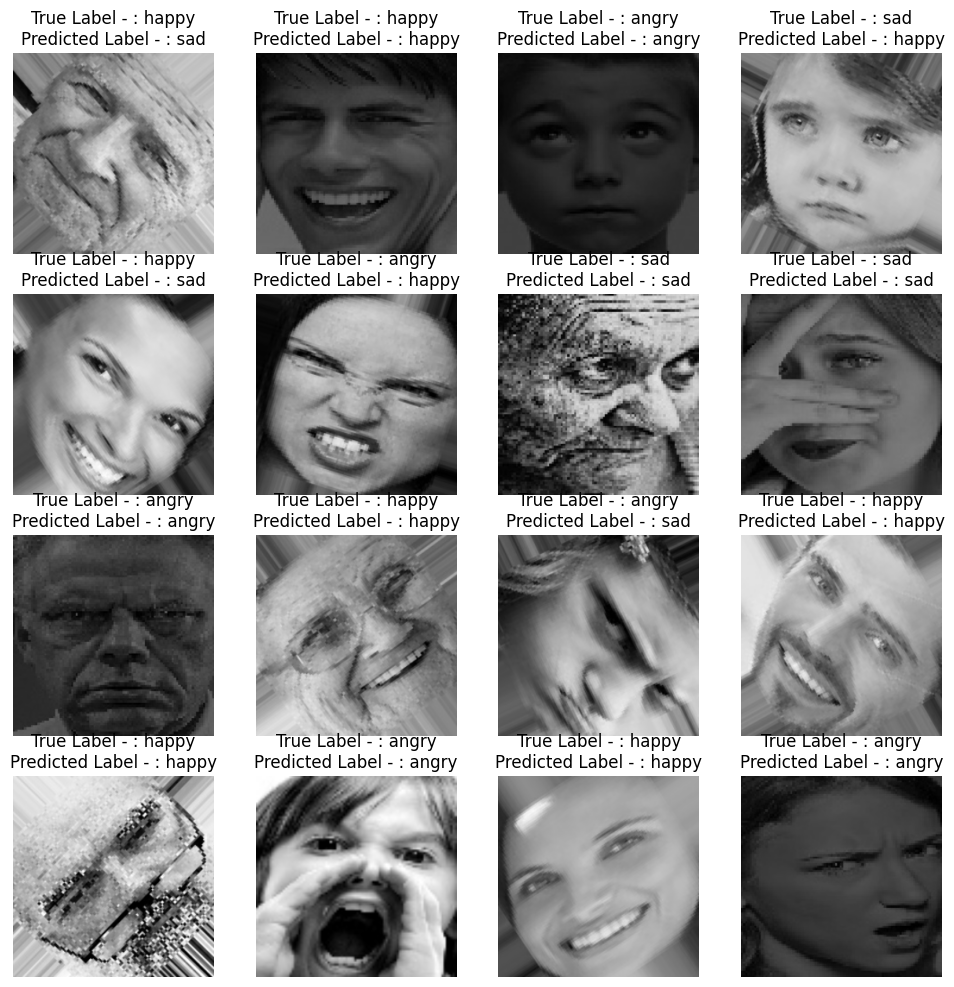

In [27]:
plt.figure(figsize = (12,12))

for images, labels in validation_dataset.take(1):
  for i in range(16):
    ax = plt.subplot(4,4, i+1)
    plt.imshow(images[i]/255.)

    plt.title("True Label - : " + CONFIGURATION["CLASS_NAMES"][tf.argmax(labels[i], axis = -1).numpy()]
              + "\n" + "Predicted Label - : "
              + CONFIGURATION["CLASS_NAMES"][int(tf.argmax(lenet_model(tf.expand_dims(images[i], axis = 0)), axis =-1).numpy()[0])] )
    plt.axis("off")

## Confusion matrix
> https://qiita.com/TsutomuNakamura/items/a1a6a02cb9bb0dcbb37f

In [31]:
predicted = []
labels = []

for im, label in validation_dataset:
  predicted.append(lenet_model(im))
  labels.append(label.numpy())


In [32]:
print(np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()]))
print(np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()]))

[1 1 2 ... 1 1 2]
[2 1 2 ... 1 1 1]


In [33]:
pred = np.concatenate([np.argmax(predicted[:-1], axis = -1).flatten(), np.argmax(predicted[-1], axis = -1).flatten()])
lab = np.concatenate([np.argmax(labels[:-1], axis = -1).flatten(), np.argmax(labels[-1], axis = -1).flatten()])

[[323  94  98]
 [ 61 831 114]
 [ 71 138 548]]


Text(0.5, 58.7222222222222, 'Predicted')

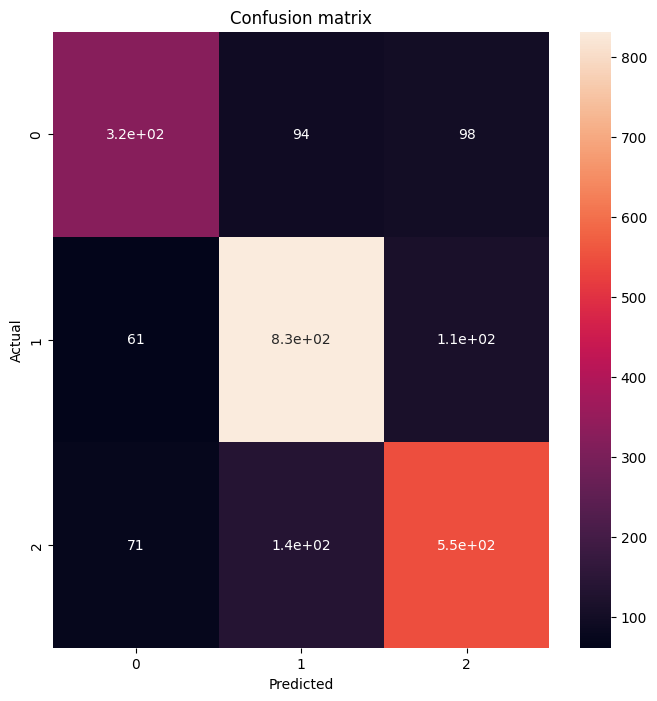

In [34]:
cm = confusion_matrix(lab, pred)
print(cm)
plt.figure(figsize=(8,8))

sns.heatmap(cm, annot=True,)
plt.title('Confusion matrix')
plt.ylabel('Actual')
plt.xlabel('Predicted')

## Data Augmentation

In [20]:
### tf.keras.layer augment
augment_layers = tf.keras.Sequential([
  RandomRotation(factor = (-0.025, 0.025)),
  RandomFlip(mode='horizontal',),
  RandomContrast(factor=0.1),
])

In [21]:
def augment_layer(image, label):
  return augment_layers(image, training = True), label

### Cutmix Augmentation

In [35]:
def box(lamda):

  r_x = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)
  r_y = tf.cast(tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1)[0], dtype = tf.int32)

  r_w = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)
  r_h = tf.cast(CONFIGURATION["IM_SIZE"]*tf.math.sqrt(1-lamda), dtype = tf.int32)

  r_x = tf.clip_by_value(r_x - r_w//2, 0, CONFIGURATION["IM_SIZE"])
  r_y = tf.clip_by_value(r_y - r_h//2, 0, CONFIGURATION["IM_SIZE"])

  x_b_r = tf.clip_by_value(r_x + r_w//2, 0, CONFIGURATION["IM_SIZE"])
  y_b_r = tf.clip_by_value(r_y + r_h//2, 0, CONFIGURATION["IM_SIZE"])

  r_w = x_b_r - r_x
  if(r_w == 0):
    r_w  = 1

  r_h = y_b_r - r_y
  if(r_h == 0):
    r_h = 1

  return r_y, r_x, r_h, r_w

このコードは、画像のサイズ CONFIGURATION["IM_SIZE"] 内でランダムな整数値を生成する処理を行っています。

### コードの解説:

1. tfp.distributions.Uniform(0, CONFIGURATION["IM_SIZE"]).sample(1):
  - tfp.distributions.Uniform は、TensorFlow Probability ライブラリが提供する一様分布を表すクラスです。
  - (0, CONFIGURATION["IM_SIZE"]) は、この一様分布の範囲を0から CONFIGURATION["IM_SIZE"] までに設定しています。
  - sample(1) は、この分布から1つのサンプルを生成するという意味です。
  - 生成されたサンプルは、0から CONFIGURATION["IM_SIZE"] までの間の浮動小数点数になります。
2. [0]:
  - 生成されたサンプルはリスト形式で返されるため、[0] で最初の要素（つまり、生成されたランダムな数値）を取り出しています。
3. tf.cast(..., dtype = tf.int32):
  - 生成された浮動小数点数を、整数型（int32）に変換しています。

### 全体として、このコードは

画像のサイズ CONFIGURATION["IM_SIZE"] 内でランダムな x 座標または y 座標を生成し、その座標を整数値に変換するという処理を行っています。

### このコードが使用される場面:

- 画像のランダムな切り出し: 画像からランダムな領域を切り出す際に、切り出す位置を決定するために使用されます。
- データ拡張: 画像データをランダムに切り出すことで、データの多様性を増やし、モデルの汎化能力を向上させるデータ拡張の手法に利用されます。
- 物体検出: 物体検出の際に、物体候補となる領域をランダムに生成する際に使用されます。

### まとめ

このコードは、画像処理において、ランダムな要素を導入するために非常に有用な機能を提供します。特に、データ拡張や物体検出などのタスクで頻繁に利用されます。

補足:

CONFIGURATION["IM_SIZE"] は、画像の幅と高さを表す変数です。
tfp.distributions は、TensorFlow Probability ライブラリであり、確率分布に関する様々な機能を提供します。

In [36]:
def cutmix(train_dataset_1, train_dataset_2):
  (image_1,label_1), (image_2, label_2) = train_dataset_1, train_dataset_2

  lamda = tfp.distributions.Beta(2,2)
  lamda = lamda.sample(1)[0]

  r_y, r_x, r_h, r_w = box(lamda)
  crop_2 = tf.image.crop_to_bounding_box(image_2, r_y, r_x, r_h, r_w)
  pad_2 = tf.image.pad_to_bounding_box(crop_2, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  crop_1 = tf.image.crop_to_bounding_box(image_1, r_y, r_x, r_h, r_w)
  pad_1 = tf.image.pad_to_bounding_box(crop_1, r_y, r_x, CONFIGURATION["IM_SIZE"], CONFIGURATION["IM_SIZE"])

  image = image_1 - pad_1 + pad_2

  lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
  label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)

  return image, label

### コードの解説
#### lamda の生成
```
lamda = tfp.distributions.Beta(2,2)
lamda = lamda.sample(1)[0]
```
このコードでは、Beta分布からランダムな値をサンプリングし、それを lamda に代入しています。

- Beta分布:
  - 0から1の間の値を取る連続確率分布です。
  - 形状パラメータが2つの場合、ほぼ一様分布に近くなります。
  - CutMixでは、この lamda を用いて、2つの画像を混合する割合を決定します。
- tfp.distributions.Beta(2,2):
  - TensorFlow Probability ライブラリを使用して、形状パラメータがともに2のBeta分布を作成します。
- lamda.sample(1)[0]:
  - 作成したBeta分布から1つのサンプルを抽出し、その値を lamda に代入します。

この lamda は、2つの画像を混合する割合を決定する重要なパラメータです。 lamda が0に近いほど image_2 の割合が大きく、1に近いほど image_1 の割合が大きくなります。

#### ラベルの混合
```
lamda = tf.cast(1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]), dtype = tf.float32)
label = lamda*tf.cast(label_1, dtype = tf.float32) + (1-lamda)*tf.cast(label_2, dtype = tf.float32)
```
このコードは、混合された画像に対応するラベルを計算しています。

- lamda の再計算:
  - r_w と r_h は、混合された領域の幅と高さです。
  - (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]) は、混合された領域が画像全体に占める割合を表します。
  - 1- (r_w*r_h)/(CONFIGURATION["IM_SIZE"]*CONFIGURATION["IM_SIZE"]) は、image_1 の割合を表します。
  - このようにして、混合された領域の割合に基づいて lamda を再計算しています。
- ラベルの混合:
  - label_1 と label_2 を float32 型に変換し、lamda を用いて重み付け平均を計算しています。

この計算により、混合された画像に対応する新しいラベルが生成されます。

### まとめ

このコード全体で、CutMixの核となる処理が行われています。
- ランダムなバウンディングボックスを生成し、2つの画像を混合する。
- 混合された画像に対応するラベルを、混合された領域の割合に基づいて計算する。

#### CutMixのメリット:

- モデルの汎化性能向上: 異なるクラスの画像を混合することで、モデルは様々なパターンを学習し、未知のデータに対しても高い精度で予測できるようになります。
- 過学習の抑制: 訓練データに過度に適合してしまうことを防ぎ、モデルの汎化能力を高めます。

#### 補足:

Beta分布は、形状パラメータを変えることで様々な分布形状を表現できます。CutMixでは、形状パラメータを(2,2)とすることで、ほぼ一様な分布とし、様々なサイズの混合領域を生成できるようにしています。
tf.cast は、データ型を変換する関数です。このコードでは、浮動小数点型と整数型の変換に使用されています。
この説明が、あなたの理解の助けになれば幸いです。